# Evaluate MPAS and FV3 ensembles
- compare severe weather surrogates and SPC storm reports
- May 2023 and 2024 Hazardous Weather Testbeds (HWT2023 and HWT2024)

### Import modules
- [contingency_table.py](contingency_table.py) and [hwt.py](hwt.py) are custom modules
- put in current directory

In [1]:
import logging
import os
import pdb
from functools import lru_cache, partial
from multiprocessing import Pool
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray

# First put contingency_table.py and hwt.py in current directory.
from contingency_table import accuracy, bias, csi, ets, far, hk, hss, pod, pofd, total
from hwt import (
    Model,
    extent,
    firstRun,
    fv3,
    helicityThresholds,
    mpas,
    projection,
    windThresholds,
)
from scipy.ndimage import maximum_filter

sns.set_theme()  # nice background on plots
logging.basicConfig(level=logging.WARNING, format="%(asctime)s %(message)s", force=True)
tmpdir = Path(os.getenv("TMPDIR"))

### Define `group`, `thresholds`, `genericnames`, `models`, `conus_mask`, and `datadir`

In [2]:
group = "wind"
thresholds = helicityThresholds if group == "uh" else windThresholds
genericnames = (
    ["0-1km UH", "0-3km UH", "2-5km UH"] if group == "uh" else ["updraft max", "10m speed max"]
)

models = [fv3, mpas]

for model in models:
    model.group = group

# assert models all have same number of variables
nvars = len(genericnames)
assert all(
    [len(model.v) == nvars for model in models]
), "Models have different number of variables to analyze"

conus_mask = xarray.open_dataarray(
    Path(os.getenv("HOME").replace(os.getenv("USER"), "ahijevyc")) / "HWT_2024.conus.nc"
)

# Replace USER with "ahijevyc". So it points to his TMPDIR, not others'.
datadir = Path(os.getenv("TMPDIR").replace(os.getenv("USER"), "ahijevyc"))

### Illustrate filter that will be applied to forecast

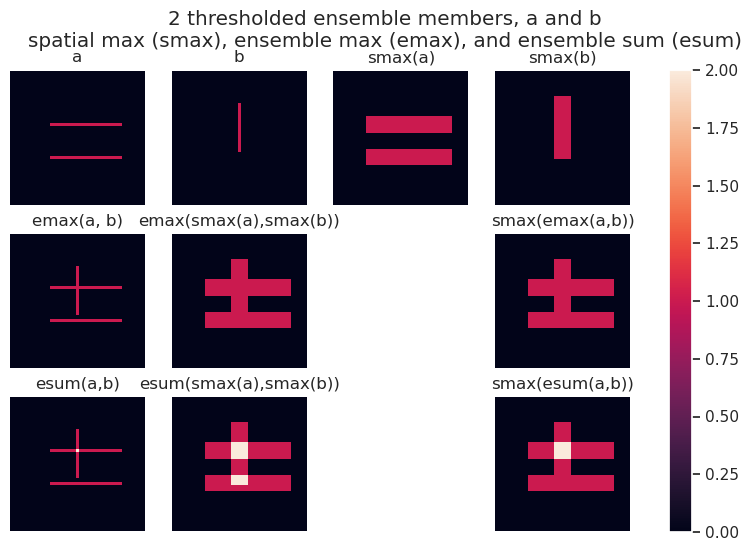

In [3]:
filter_size1 = (
    25  # max-filter size before summing ensemble members. already applied in make_fy_fo.ipynb
)
filter_size2 = 25  # apply another max-filter here.

a = np.zeros((41, 41))  # all zero, square matrix
b = np.zeros((41, 41))  # all zero, square matrix
a[16, 12:34] = 1  # except two points are equal to one
a[26, 12:34] = 1  # except two points are equal to one
b[10:25, 20] = 1


def mx(x, filter_size=5):
    return maximum_filter(x, size=filter_size)


fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(10, 6))

fig.suptitle(
    "2 thresholded ensemble members, a and b"
    "\nspatial max (smax), ensemble max (emax), and ensemble sum (esum)"
)
vmax = 2
axes[0, 0].imshow(a, interpolation="nearest", vmax=vmax)
axes[0, 0].set_title("a")
axes[0, 1].imshow(b, interpolation="nearest", vmax=vmax)
axes[0, 1].set_title("b")
axes[0, 2].imshow(mx(a), interpolation="nearest", vmax=vmax)
axes[0, 2].set_title("smax(a)")
axes[0, 3].imshow(mx(b), interpolation="nearest", vmax=vmax)
axes[0, 3].set_title("smax(b)")


axes[1, 0].imshow(np.max(np.stack([a, b]), axis=0), interpolation="nearest", vmax=vmax)
axes[1, 0].set_title("emax(a, b)")
axes[1, 1].imshow(np.max(np.stack([mx(a), mx(b)]), axis=0), interpolation="nearest", vmax=vmax)
axes[1, 1].set_title("emax(smax(a),smax(b))")
axes[1, 3].imshow(mx(np.max(np.stack([a, b]), axis=0)), interpolation="nearest", vmax=vmax)
axes[1, 3].set_title("smax(emax(a,b))")

axes[2, 0].imshow(a + b, vmax=vmax)
axes[2, 0].set_title("esum(a,b)")
axes[2, 1].imshow(mx(a) + mx(b), interpolation="nearest", vmax=vmax)
axes[2, 1].set_title("esum(smax(a),smax(b))")
_ = axes[2, 3].imshow(mx(a + b), interpolation="nearest", vmax=vmax)
axes[2, 3].set_title("smax(esum(a,b))")

fig.colorbar(_, ax=axes)
_ = [ax.set_axis_off() for ax in axes.flat]

In [4]:
thresholds

<xarray.DataArray (thresh: 10)> Size: 80B
array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
Dimensions without coordinates: thresh
Attributes:
    units:       $m/s$
    short_name:  wind

In [5]:
@lru_cache(maxsize=2, typed=False)
def get_obs(datadir: Path, valid_date: pd.Timestamp) -> xarray.DataArray:
    """
    Get observation DataArray.
    Mask it with CONUS.
    """
    rptfile = datadir / f"near_rpt.{valid_date.strftime('%Y-%m-%d %H:%M:%S')}.nc"
    logging.info(f"open existing {rptfile}")
    obs = xarray.open_dataarray(rptfile)
    logging.info(f"opened existing {rptfile}")
    any = obs.max(dim="rpt_type").assign_coords(rpt_type="any")
    obs = xarray.concat([obs, any], dim="rpt_type")

    # Keep obs where conus_mask is True; otherwise set to nan.
    # nans will propagate to h, m, f, and n and not be counted when the .sum() function
    # is used below.
    obs = obs.where(conus_mask)
    obs.name = "obs"
    del obs.attrs["units"]
    del obs.attrs["long_name"]
    obs["valid_date"] = valid_date

    return obs


def get_fcst(
    datadir: Path,
    model: Model,
    group: str,
    valid_date: pd.Timestamp,
) -> xarray.DataArray:
    """
    Get forecast DataArray.
    Encode source filename.
    Assert no missing data.
    Don't mask it like get_obs() does. We mask after spatial filtering.
    """
    idir = Path(f"/glade/campaign/mmm/parc/schwartz/HWT2024/{model}")
    logging.info(f"size-{filter_size1} max filter")
    ncfile = datadir / (
        f"forecast_yes.{model}.{group}.{filter_size1}.{valid_date.strftime('%Y%m%d')}.nc"
    )
    logging.info(f"open existing {ncfile}")
    fcst = xarray.open_dataarray(ncfile)
    fcst.encoding["source"] = ncfile
    # Assign generic variable names instead of model-dependent names.
    fcst = fcst.assign_coords({"variable": genericnames})
    assert not fcst.isnull().any(), f"{fcst.isnull().sum()} null in {fcst.name}"
    assert fcst.min() >= 0, f"{ncfile} min < 0 {fcst.min()}"
    # Tried DataArray.equal but thresholds has dimension w/o coordinates
    assert all(fcst.thresh == thresholds), f"{fcst.thresh} != {thresholds}"

    londim = fcst.dims.index("lon")
    latdim = fcst.dims.index("lat")
    logging.info(f"size-{filter_size2} max filter")
    fcst.values = maximum_filter(fcst.values, size=filter_size2, axes=(londim, latdim))
    fcst.attrs["filter_size"] = filter_size2
    fcst["valid_date"] = valid_date
    return fcst


def scalarL1L2Norms(fcst: xarray.DataArray, obs: xarray.DataArray) -> xarray.Dataset:
    # scalarL1L2 named like in Meteorological Evaluation Tools (MET)

    fcstObs = fcst * obs
    fcstObs.name = fcst.name + obs.name
    fcstFcst = fcst**2
    fcstFcst.name = fcst.name + fcst.name
    obsObs = obs**2
    obsObs.name = obs.name + obs.name

    ds = xarray.merge([fcst, obs, fcstObs, fcstFcst, obsObs])
    return ds

In [6]:
def get_hmfn(valid_date: pd.Timestamp, model: Model):
    """
    Match forecast and observations
    for one valid date and model.
    Calculate hits, misses, false alarms, and correct nulls.
    Return contingency table (hmfn) and L1 and L2 norms.

    Apply a filter_size maximum filter to forecast first
    """
    fcst = get_fcst(datadir, model, group, valid_date)
    # Define observations
    obs = get_obs(datadir, valid_date)

    # Use == 1 and == 0 to avoid masked points. You can't use ~fcst because you can't negate a masked point.
    # fcst > 0 so fcst is a yes forecast if ANY of the members are yes.
    h = (fcst > 0) * (obs == 1)
    m = (fcst == 0) * (obs == 1)
    f = (fcst > 0) * (obs == 0)
    n = (fcst == 0) * (obs == 0)
    counts = ["hits", "misses", "false alarms", "correct nulls"]
    hmfn = (
        xarray.concat([h, m, f, n], dim="count")
        .sum(dim=["lon", "lat"])
        .assign_coords(count=counts, valid_date=valid_date, model=str(model))
        .expand_dims(["valid_date", "model"])
    )

    hmfn.name = fcst.name
    hmfn.attrs = fcst.attrs
    logging.info("made hmfn")
    print(f"{valid_date} {model}", end=" ")
    return hmfn


def get_sl1l2(valid_date: pd.Timestamp, model: Model | xarray.DataArray):
    """
    Divide # members over threshold (fcst) by # members
    to get probability.

    Call scalarL1L2Norms with fcst and obs.
    """

    if type(model) == xarray.DataArray:
        fcst = model
        model = "climo"
    else:
        fcst = get_fcst(datadir, model, group, valid_date)
        fcst = fcst / fcst.attrs["nmem"]
    fcst.name = "fcst"
    fcst.attrs["long_name"] = "fcst probability"
    assert fcst.min() >= 0, f"{valid_date} {model} min fcst<0 {fcst.min()}"
    assert fcst.max() <= 1, f"{valid_date} {model} min fcst>=1 {fcst.max()}"
    logging.info("made fcst")

    # mask conus sum of forecasts will have ocean too. Can't use ~fcst however.
    fcst = fcst.where(conus_mask)

    # Define observations
    obs = get_obs(datadir, valid_date)

    sl1l2 = scalarL1L2Norms(fcst, obs)

    sl1l2 = (
        sl1l2.sum(dim=["lon", "lat"])
        .assign_coords(valid_date=valid_date)
        .expand_dims("valid_date")
    )
    if model != "climo":
        sl1l2 = sl1l1.assign_coords(model=str(model)).expand_dims("model")

    sl1l2.attrs = fcst.attrs
    print(f"{valid_date} {model}", end=" ")
    return sl1l2


# Use climatological frequency of "torn" "wind" "hail" "all" as reference forecast
# when calculating Skill Score. This must be calculated beforehand
# to define it statically, like this. See how this is done below.
rpt_types = ["torn", "wind", "hail", "any"]
climo = xarray.DataArray([0.003963, 0.01895, 0.01454, 0.02948], coords={"rpt_type": rpt_types})

## Get contingency table and Brier Score for all valid dates.
- First time this is executed, calculate the table and Brier Score for each date
    - This takes hours unless multiprocessing is used.
    - Process multiple valid dates in parallel.
    - Reserve enough memory beforehand--more jobs in parallel require more memory.
    - Save data to disk.
- Subsequent times, it will read the data from disk.

In [7]:
sfx = (
    f".2023-2024.{group}{len(genericnames)}.{len(thresholds)}.{filter_size1},{filter_size2}.nc"
)
d2023 = pd.date_range(start=firstRun(2023), end="20230531", freq="1D")
d2024 = pd.date_range(start=firstRun(2024), end="20240531", freq="1D")
valid_dates = d2023.union(d2024)

processes = 1
# list of (date, model) tuples for multiprocessing pool.
joblist = [(valid_date, model) for valid_date in valid_dates for model in models]

# Call multiprocessing and return a Dataset three times for hmfn, sl1l2ref.
# If you call multiprocessing and make all three datasets, you use mucho memory.


# Hits, misses, false alarms and nulls.
ofile = datadir / f"hmfn{sfx}"
if not os.path.exists(ofile):
    logging.warning(f"make {ofile}")
    with Pool(processes=processes) as pool:
        hmfn = pool.starmap(
            get_hmfn,
            joblist,
        )

    hmfn = xarray.combine_by_coords(
        hmfn,
        combine_attrs="drop_conflicts",
    )
    hmfn.to_netcdf(ofile)
    logging.warning(ofile)
logging.warning(f"open {ofile}")
hmfn = xarray.open_dataarray(ofile)  # needs to be dataarray, not


# Scalar L1 and L2 norms
ofile2 = datadir / f"SL1L2{sfx}"
if os.path.exists(ofile2):
    logging.warning(f"open {ofile2}")
    SL1L2 = xarray.open_dataset(ofile2)
else:
    logging.warning(f"make {ofile2}")
    with Pool(processes=processes) as pool:
        SL1L2 = pool.starmap(
            get_sl1l2,
            joblist,
        )

    SL1L2 = xarray.combine_by_coords(
        SL1L2,
        combine_attrs="drop_conflicts",
    )
    SL1L2.to_netcdf(ofile2)
    logging.warning(ofile2)


# fcst = climo
ofile3 = datadir / "SL1L2ref.2023-2024.nc"
if os.path.exists(ofile3):
    logging.warning(f"open {ofile3}")
    SL1L2ref = xarray.open_dataset(ofile3)
else:
    logging.warning(f"make {ofile3}")
    if processes > 1:
        with Pool(processes=processes) as pool:
            SL1L2ref = pool.starmap(
                get_sl1l2,
                [(valid_date, climo) for valid_date in valid_dates],
            )
    else:
        SL1L2ref = [get_sl1l2(valid_date, climo) for valid_date in valid_dates]

    SL1L2ref = xarray.combine_by_coords(
        SL1L2ref,
        combine_attrs="drop_conflicts",
    )
    SL1L2ref.to_netcdf(ofile3)
    logging.warning(ofile3)

2024-10-13 15:09:21,811 open /glade/derecho/scratch/ahijevyc/tmp/hmfn.2023-2024.wind2.10.25,25.nc
2024-10-13 15:09:21,827 open /glade/derecho/scratch/ahijevyc/tmp/SL1L2.2023-2024.wind2.10.25,25.nc
2024-10-13 15:09:21,837 open /glade/derecho/scratch/ahijevyc/tmp/SL1L2ref.2023-2024.nc


In [8]:
SL1L2ref

<xarray.Dataset> Size: 14kB
Dimensions:     (valid_date: 80, rpt_type: 4)
Coordinates:
  * rpt_type    (rpt_type) <U4 64B 'torn' 'wind' 'hail' 'any'
  * valid_date  (valid_date) datetime64[ns] 640B 2023-04-24 ... 2024-05-31
Data variables:
    fcst        (valid_date, rpt_type) float64 3kB ...
    obs         (valid_date, rpt_type) float64 3kB ...
    fcstobs     (valid_date, rpt_type) float64 3kB ...
    fcstfcst    (valid_date, rpt_type) float64 3kB ...
    obsobs      (valid_date, rpt_type) float64 3kB ...
Attributes:
    long_name:  fcst probability

## Plot results
For example, equitable threat score (ets), bias, Heidke Skill Score (hss), false alarm ratio

- Equitable Threat Score is proportion hits (CSI) w/o chance
- Heidke Skill Score is proportion hits & correct nulls (accuracy) w/o chance
  
### Ways to stratify results
- model
- dayForecast
- valid_date
- threshold
- variable
- rpt_type

2024-10-13 15:09:24,492 /glade/derecho/scratch/ahijevyc/tmp/ets.2023-2024.wind2.10.25,25.png


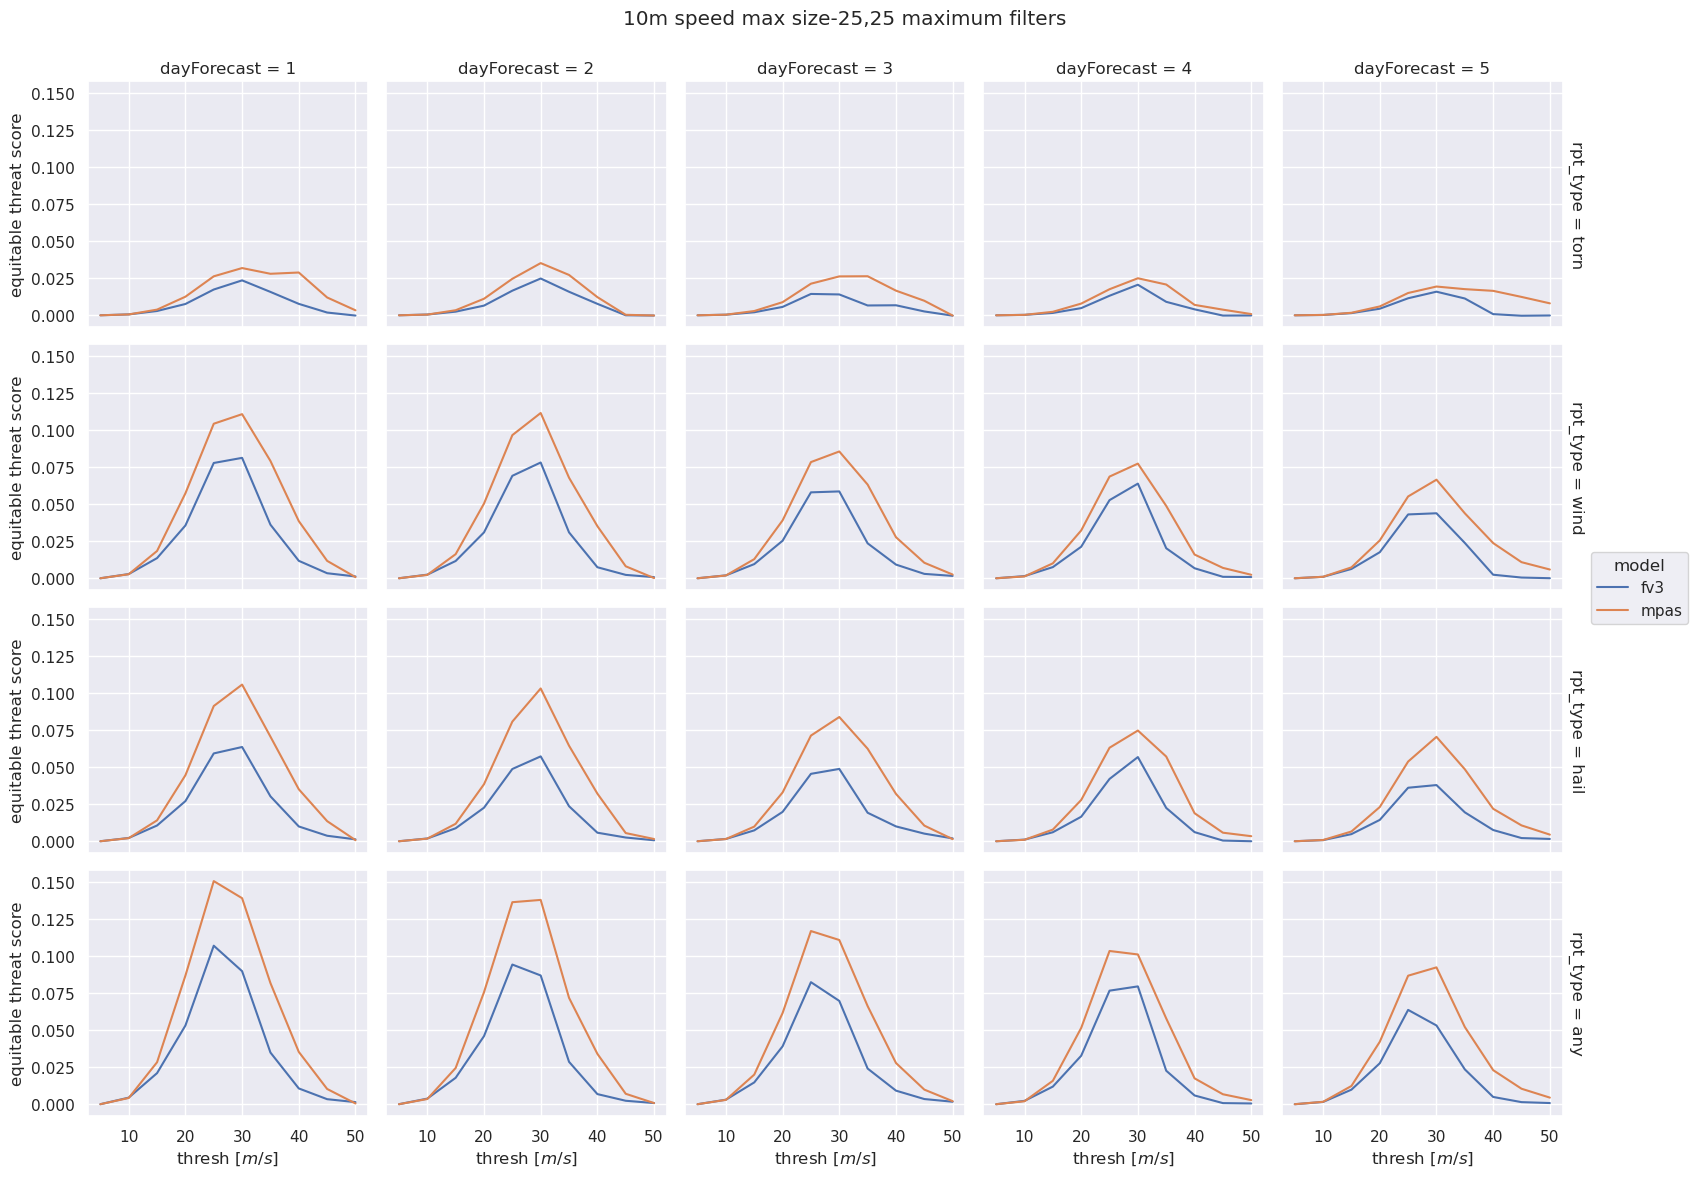

In [9]:
variable = genericnames[1]
s = hmfn
# s = s.where(s.valid_date > pd.to_datetime("20240101")) # just one year
s = s.sel(dayForecast=slice(1, 5))  # just dayForecast 1-5
s = s.mean(dim="valid_date")
s = s.sel(variable=variable)
s = ets(s)
g = s.plot(col="dayForecast", row="rpt_type", hue="model")
g.fig.suptitle(f"{variable} size-{filter_size1},{filter_size2} maximum filters")
ofile = tmpdir / f"{s.attrs['short_name']}{sfx.rstrip('.nc')}.png"
g.fig.subplots_adjust(top=0.92)
g.fig.savefig(ofile, dpi=150)
logging.warning(ofile)

/glade/derecho/scratch/ahijevyc/tmp/ets.2023-2024.wind2.10.25,25.png


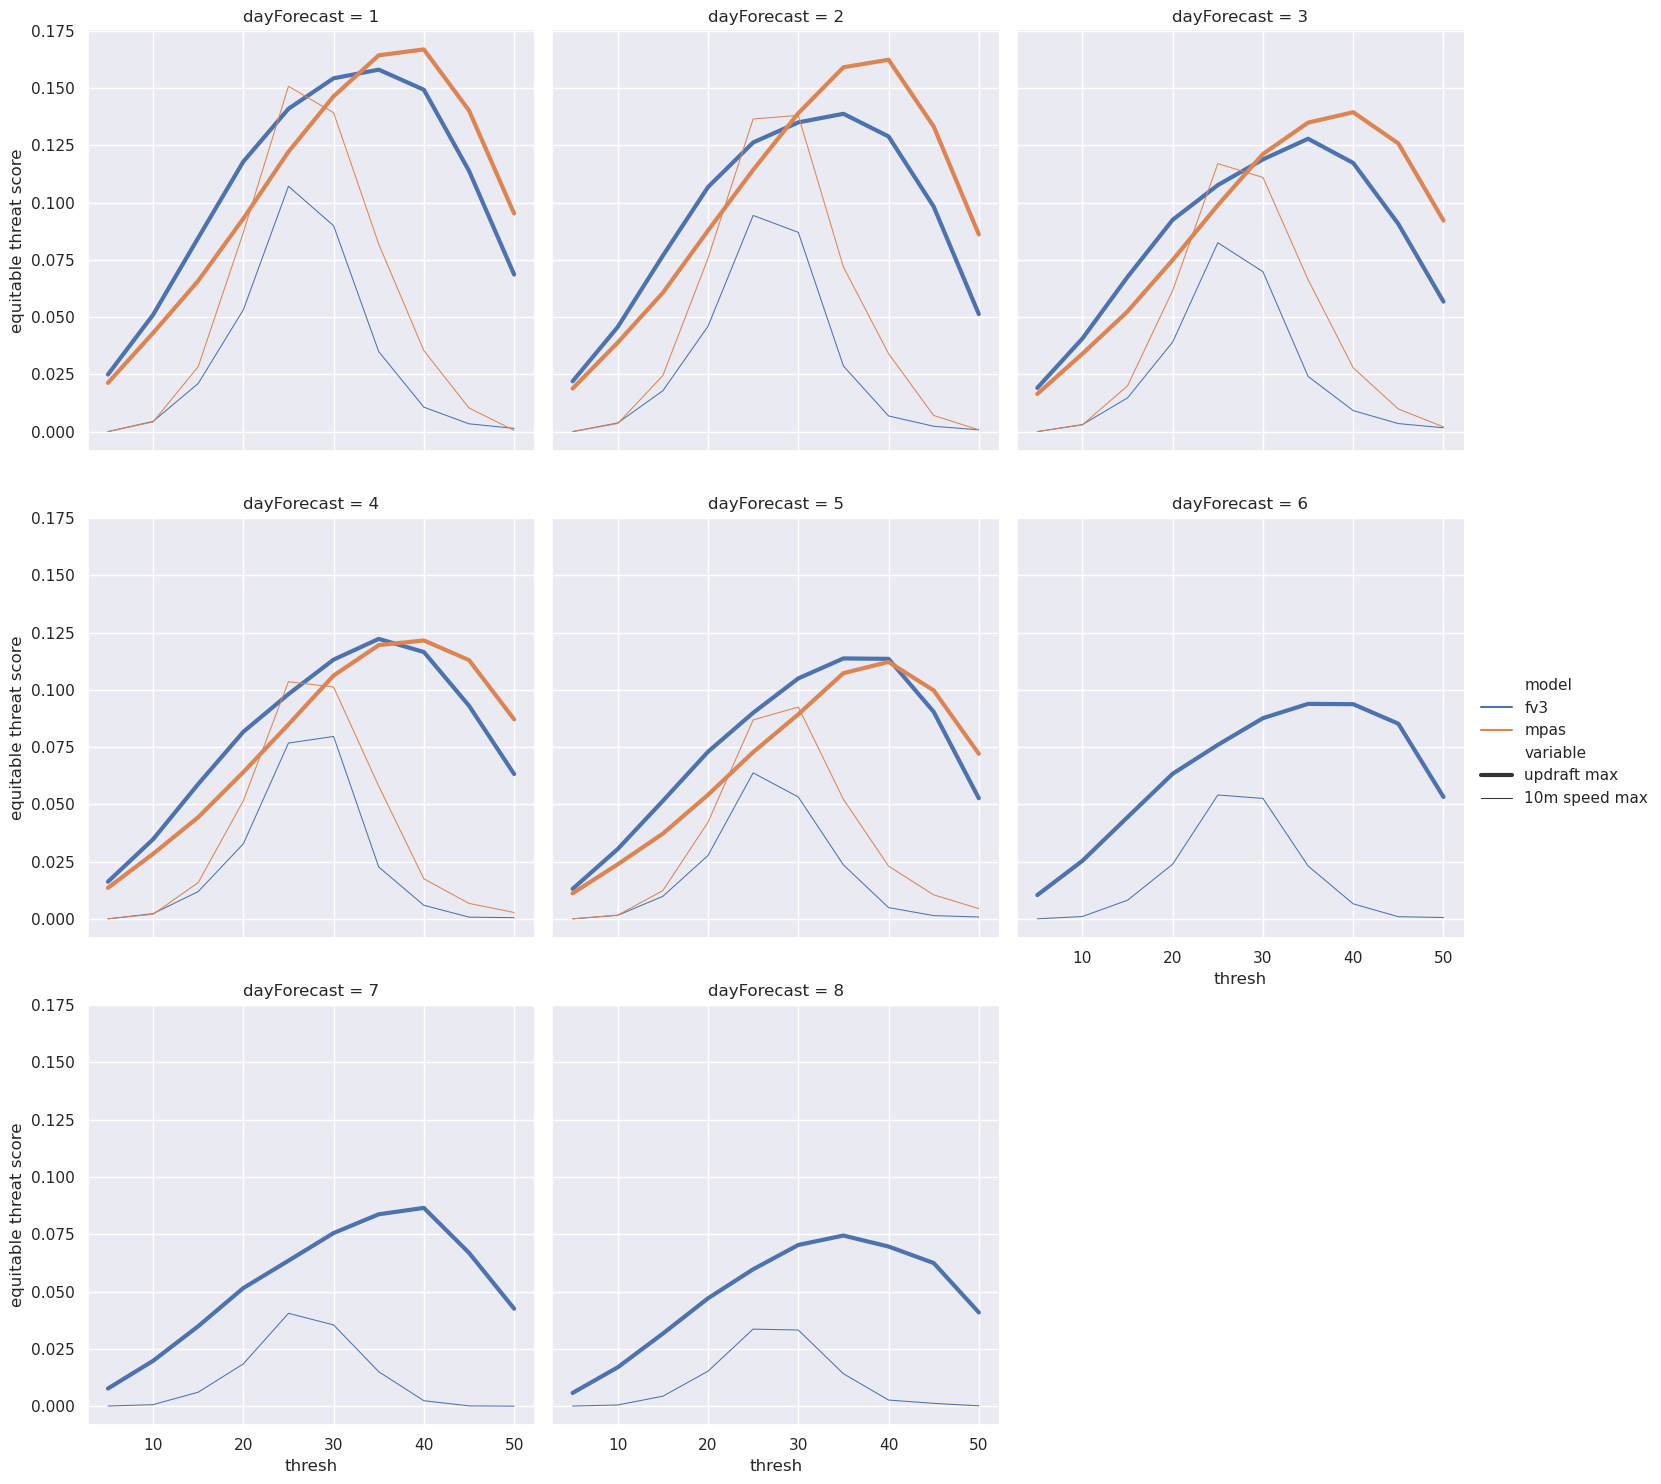

In [10]:
rpt_type = "any"
s = hmfn
s = ets(s.sum(dim="valid_date"))
g = sns.relplot(
    data=s.sel(rpt_type=rpt_type).to_dataframe().reset_index(),
    col="dayForecast",
    col_wrap=3,
    y="equitable threat score",
    x="thresh",
    kind="line",
    hue="model",
    size="variable",
)
ofile = tmpdir / f"{s.attrs['short_name']}{sfx.rstrip('.nc')}.png"
g.savefig(ofile)
print(ofile)

/glade/derecho/scratch/ahijevyc/tmp/ets.2023-2024.wind2.10.25,25.3.fv3.10m speed max.png


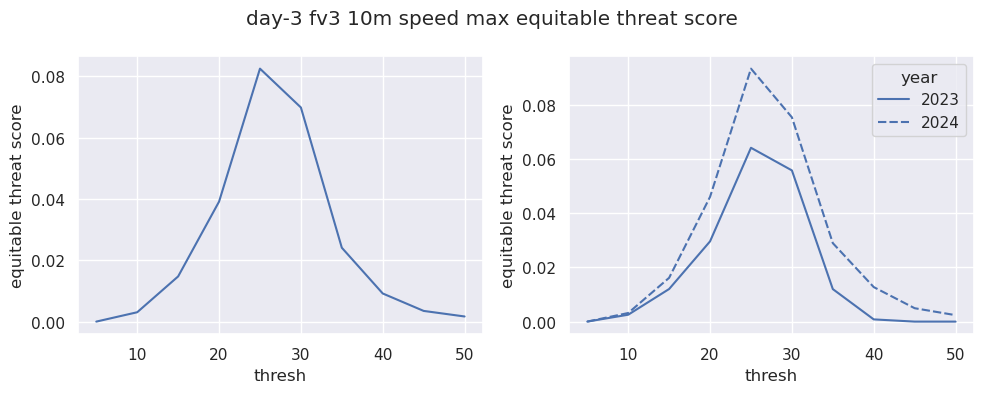

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
s = ets(hmfn.sum(dim="valid_date"))
sel = dict(
    dayForecast=3,
    model="fv3",
    rpt_type=rpt_type,
    variable=variable,
)
y = "equitable threat score"
g = sns.lineplot(
    s.sel(sel).to_dataframe().reset_index(),
    ax=axes[0],
    y=y,
    x="thresh",
)
s = hmfn
s["year"] = s["valid_date"].dt.year
s = ets(s.groupby("year").sum(dim="valid_date"))
g = sns.lineplot(
    ax=axes[1],
    data=s.sel(sel).to_dataframe().reset_index(),
    y=y,
    x="thresh",
    style="year",
)
ofile = (
    tmpdir
    / f"{s.attrs['short_name']}{sfx.rstrip('.nc')}.{sel['dayForecast']}.{sel['model']}.{sel['variable']}.png"
)
plt.suptitle(f"day-{sel['dayForecast']} {sel['model']} {sel['variable']} {y}")
plt.tight_layout()
fig.savefig(ofile)
print(ofile)

/glade/derecho/scratch/ahijevyc/tmp/ets.2023-2024.wind2.10.25,25.10m speed max.png


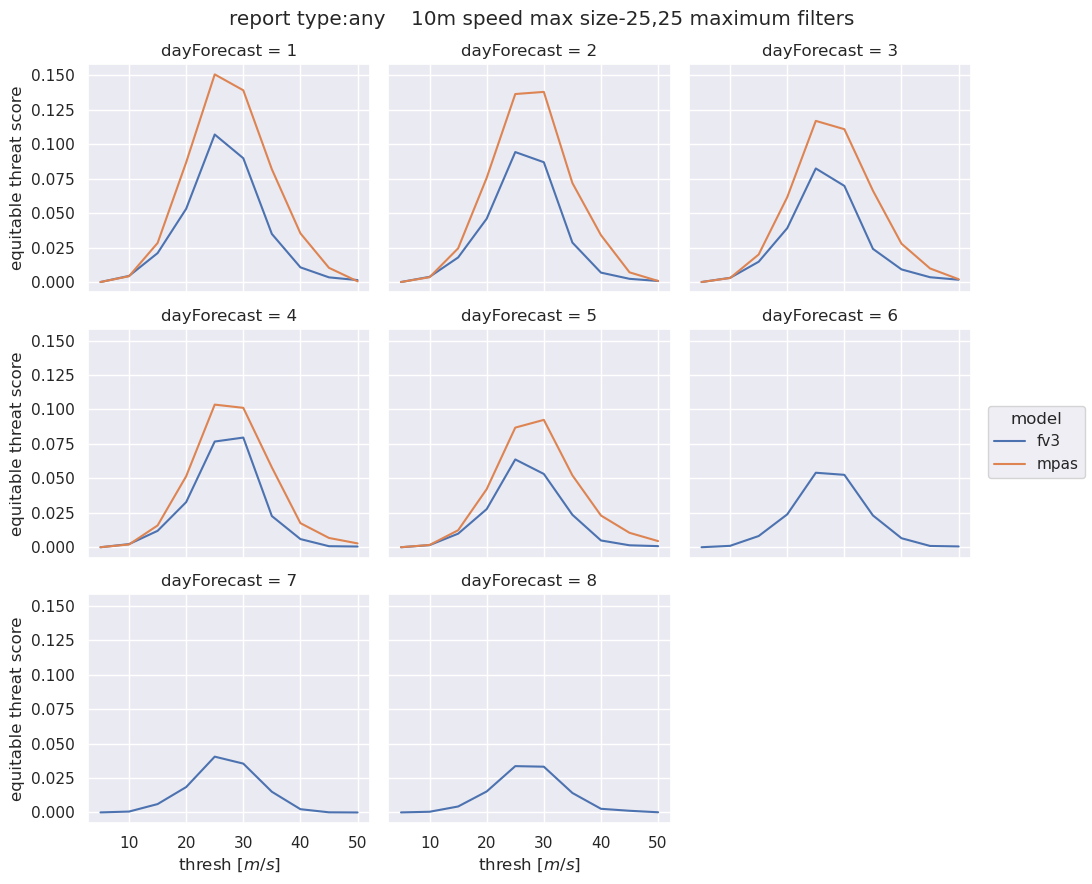

In [12]:
s = hmfn
s = ets(hmfn.sum(dim="valid_date"))
g = s.sel(variable=variable, rpt_type=rpt_type).plot(col="dayForecast", hue="model", col_wrap=3)
g.fig.suptitle(
    f"report type:{rpt_type}    {variable} size-{filter_size1},{filter_size2} maximum filters"
)
ofile = tmpdir / f"{s.attrs['short_name']}{sfx.rstrip('.nc')}.{sel['variable']}.png"
g.fig.subplots_adjust(top=0.92)
g.fig.savefig(ofile)
print(ofile)

### Aggregate dayForecasts

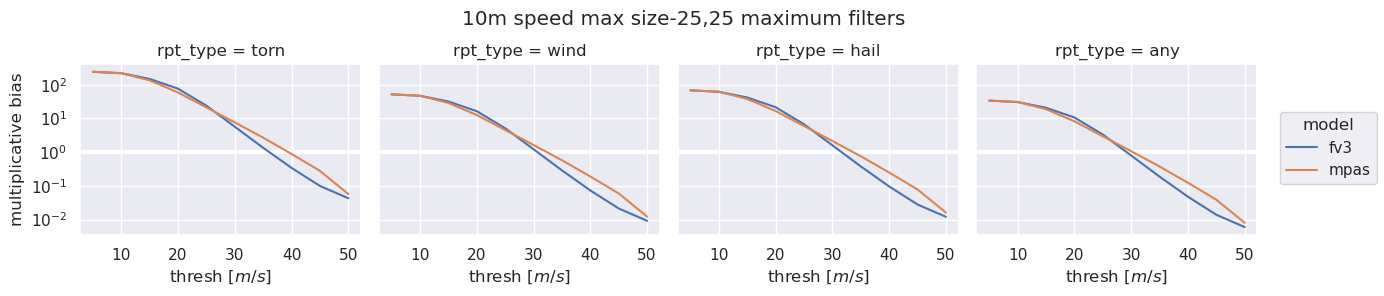

In [13]:
def noBiasLine(g, lw=3, color="w", zorder=1, **kwargs):
    [ax.axhline(y=1, lw=lw, color=color, zorder=zorder, **kwargs) for ax in g.axs.flatten()]


s = bias(hmfn.sel(dayForecast=slice(1, 5)).sum(dim="valid_date").sum(dim="dayForecast"))
g = s.sel(variable=variable).plot(col="rpt_type", hue="model", yscale="log")
noBiasLine(g)
g.fig.suptitle(f"{variable} size-{filter_size1},{filter_size2} maximum filters")
g.fig.subplots_adjust(top=0.8)

<xarray.DataArray (valid_date: 71, model: 2, thresh: 10, variable: 2,
                   dayForecast: 5, rpt_type: 4)> Size: 454kB
array([[[[[[4.14554089e+02, 1.91208514e+01, 1.03722792e+01,
            7.34992143e+00],
           [4.33883821e+02, 2.00665240e+01, 1.09512271e+01,
            7.76681192e+00],
           [3.51537776e+02, 1.63743402e+01, 8.96676115e+00,
            6.36529371e+00],
           [2.45852058e+02, 1.17303606e+01, 6.66302120e+00,
            4.80794107e+00],
           [1.98699850e+02, 9.92603339e+00, 5.38657752e+00,
            4.04709282e+00]],

          [[2.39518666e+03, 1.14749325e+02, 6.43674014e+01,
            4.69546269e+01],
           [2.39413906e+03, 1.14698721e+02, 6.43388159e+01,
            4.69336532e+01],
           [2.39469551e+03, 1.14725600e+02, 6.43539996e+01,
            4.69447937e+01],
           [2.39372490e+03, 1.14678715e+02, 6.43275149e+01,
            4.69253614e+01],
           [2.38893904e+03, 1.14447536e+02, 6.41969248e+01,
...
            1.00235669e+00],
           [1.22386669e+00, 1.01373663e+00, 1.01665564e+00,
            1.00325224e+00],
           [1.62677646e+00, 1.00298352e+00, 1.13660462e+00,
            1.00328040e+00],
           [1.53164954e+00, 1.07917778e+00, 1.11165386e+00,
            1.05132092e+00],
           [1.25972247e+00, 1.00910979e+00, 1.05505127e+00,
            1.01233916e+00]],

          [[1.00240272e+00, 1.01526177e+00, 1.00889964e+00,
            1.02340493e+00],
           [1.00240272e+00, 1.01526177e+00, 1.00889964e+00,
            1.02340493e+00],
           [1.02828124e+00, 1.00006747e+00, 1.00518393e+00,
            1.01341682e+00],
           [1.00361870e+00, 1.01491333e+00, 1.00923277e+00,
            1.02317588e+00],
           [1.06271837e+00, 1.00517699e+00, 1.01218398e+00,
            1.01677561e+00]]]]]])
Coordinates:
  * dayForecast  (dayForecast) int64 40B 1 2 3 4 5
  * thresh       (thresh) int64 80B 5 10 15 20 25 30 35 40 45 50
  * variable     (variable) <U13 104B 'updraft max' '10m speed max'
  * valid_date   (valid_date) datetime64[ns] 568B 2023-04-28 ... 2024-05-31
  * model        (model) <U4 32B 'fv3' 'mpas'
  * rpt_type     (rpt_type) <U4 64B 'torn' 'wind' 'hail' 'any'

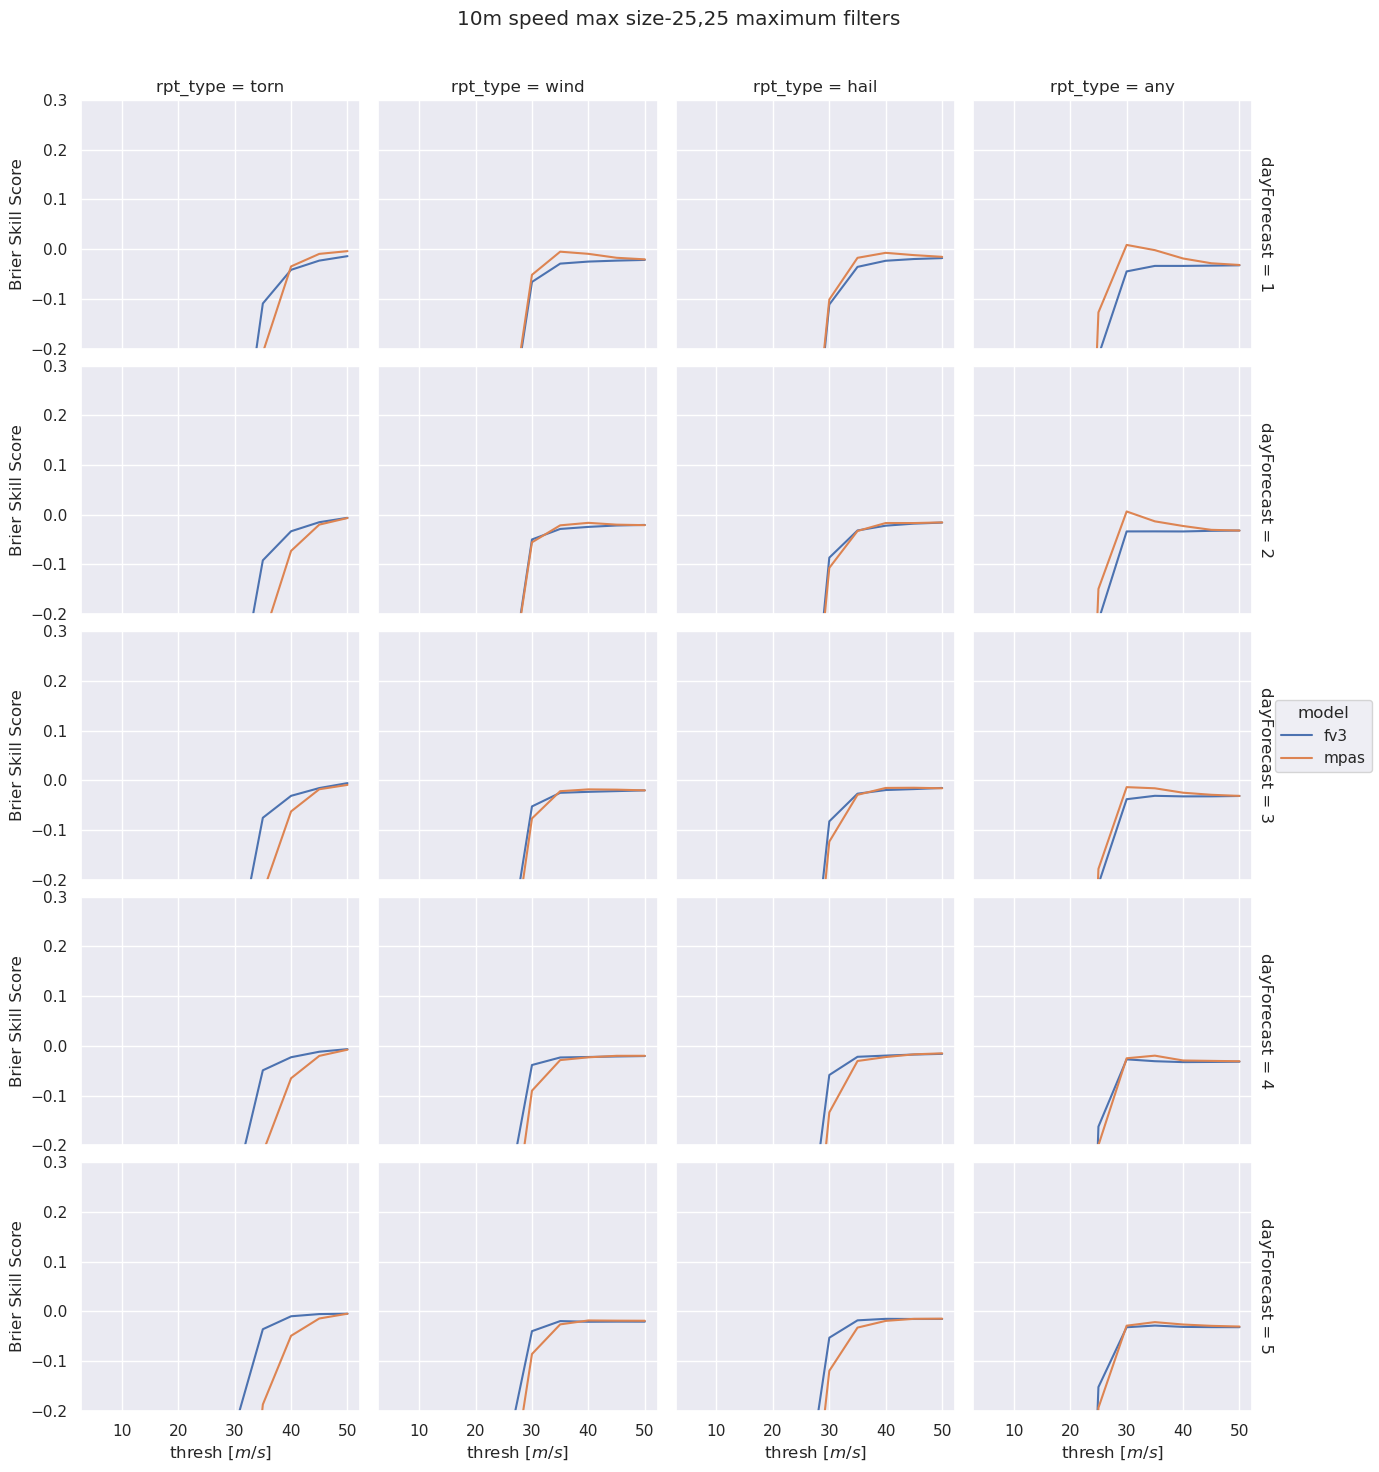

In [116]:
se = SL1L2.fcstfcst + SL1L2.obsobs - 2 * SL1L2.fcstobs
se_ref = SL1L2ref.fcstfcst + SL1L2ref.obsobs - 2 * SL1L2ref.fcstobs
ivalid_date = (
    (firstRun(2023) + pd.to_timedelta("4D") <= se.valid_date) & (se.valid_date < firstRun(2024))
) | (se.valid_date > (firstRun(2024) + pd.to_timedelta("4D")))
s = 1 - se.sel(valid_date=ivalid_date, dayForecast=slice(1, 5)).mean(dim="valid_date")/se_ref.sel(valid_date=ivalid_date).mean(dim="valid_date")
s.name = "Brier Skill Score"
s.attrs["short_name"] = "bss"
g = s.sel(variable=variable).plot(col="rpt_type", row="dayForecast", hue="model")
[ax.set(ylim=(-0.2, 0.3)) for ax in g.axs.ravel()]
g.fig.suptitle(f"{variable} size-{filter_size1},{filter_size2} maximum filters")
g.fig.subplots_adjust(top=0.92)

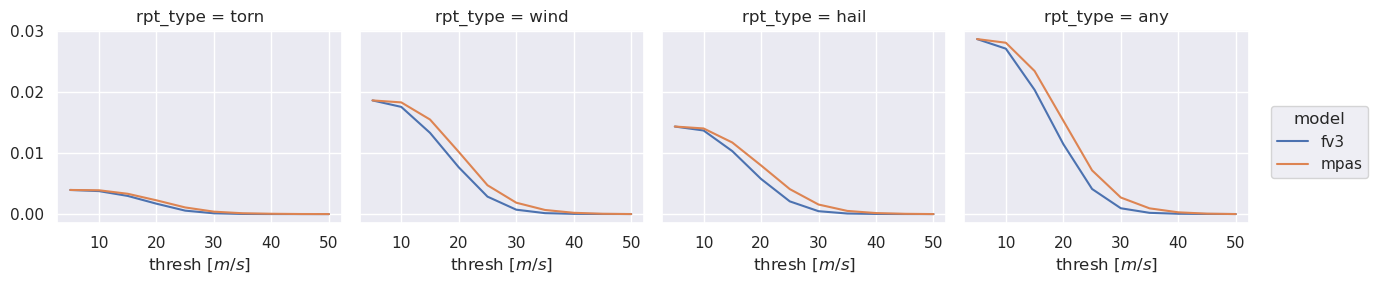

In [35]:
(SL1L2.fcstobs / total(hmfn)).mean(dim="valid_date").sel(dayForecast=1, variable=variable).plot(
    col="rpt_type", hue="model"
)

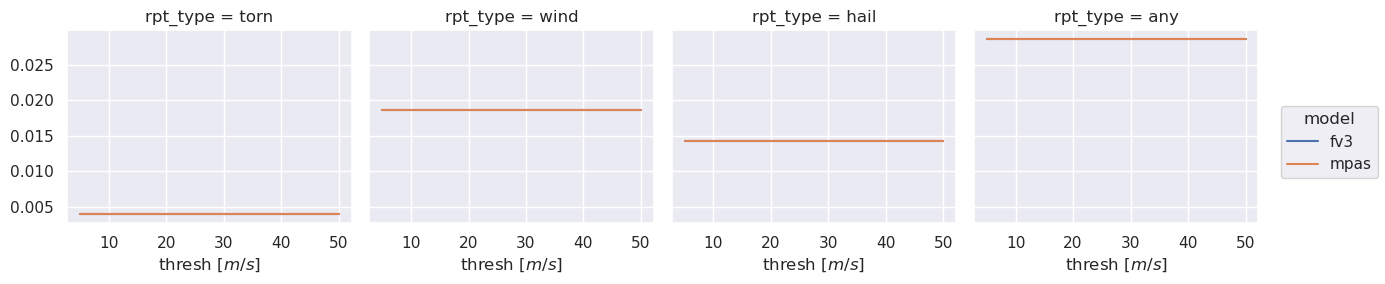

In [15]:
(SL1L2.obs / total(hmfn)).mean(dim="valid_date").sel(dayForecast=1, variable=variable).plot(
    col="rpt_type", hue="model"
)

In [17]:
def performance_diagram(color=None, label=None):
    """
    performace diagram
    xaxis = 1-far
    yaxis = prob of detection
    where far = fp / (tp+fp)
    """
    ax = plt.gca()
    bias_lines = [0.2, 0.5, 0.8, 1, 1.3, 2, 5]
    csi_lines = np.arange(0.1, 1.0, 0.1)
    alpha = 0.8
    lw = 1
    color = "0.8"
    bias_pts = [
        [sr * b for sr in [0, 1.0]] for b in bias_lines
    ]  # compute pod values for each bias line
    csi_pts = np.array(
        [
            [csi / (csi - (csi / sr) + 1) for sr in np.arange(0.011, 1.01, 0.005)]
            for csi in csi_lines
        ]
    )  # compute pod values for each csi line
    csi_pts = np.ma.masked_array(csi_pts, mask=(csi_pts < 0.05))

    # add bias and CSI lines to performance diagram
    for r in bias_pts:
        ax.plot([0, 1], r, color=color, linestyle="dashed", lw=lw, alpha=alpha)
    for r in csi_pts:
        ax.plot(
            np.arange(0.01, 1.01, 0.005),
            r,
            color=color,
            alpha=alpha,
            linestyle="solid",
            linewidth=lw,
        )
    for x in [b for b in bias_lines if b <= 1]:
        ax.text(1.002, x, x, va="center", ha="left", fontsize="x-small", color="0.5")
    for x in [b for b in bias_lines if b > 1]:
        ax.text(1 / x, 1, x, va="baseline", ha="center", fontsize="xx-small", color="0.5")

    # axes limits, labels
    ax.set_xlim((0, 1))
    ax.set_ylim((0, 1))
    return ax

In [18]:
x = 1 - far(hmfn.sel(dayForecast=slice(1, 5)).sum(dim="valid_date"))
x.name = "1-far"
y = pod(hmfn.sel(dayForecast=slice(1, 5)).sum(dim="valid_date"))
data = xarray.merge([x, y], compat="override")
data = data.sel(variable=variable).to_dataframe().drop(columns="count").reset_index(drop=False)
data

,dayForecast,thresh,rpt_type,model,variable,1-far,probability of detection
0,1,5,torn,fv3,10m speed max,0.003949,1.000000
1,1,5,torn,mpas,10m speed max,0.003948,1.000000
2,1,5,wind,fv3,10m speed max,0.018608,1.000000
3,1,5,wind,mpas,10m speed max,0.018600,1.000000
4,1,5,hail,fv3,10m speed max,0.014334,1.000000
...,...,...,...,...,...,...,...
395,5,50,wind,mpas,10m speed max,0.318088,0.006391
396,5,50,hail,fv3,10m speed max,0.202106,0.001682
397,5,50,hail,mpas,10m speed max,0.186153,0.004962
398,5,50,any,fv3,10m speed max,0.224385,0.000920


performance_diagram.day1-5.10m speed max.png


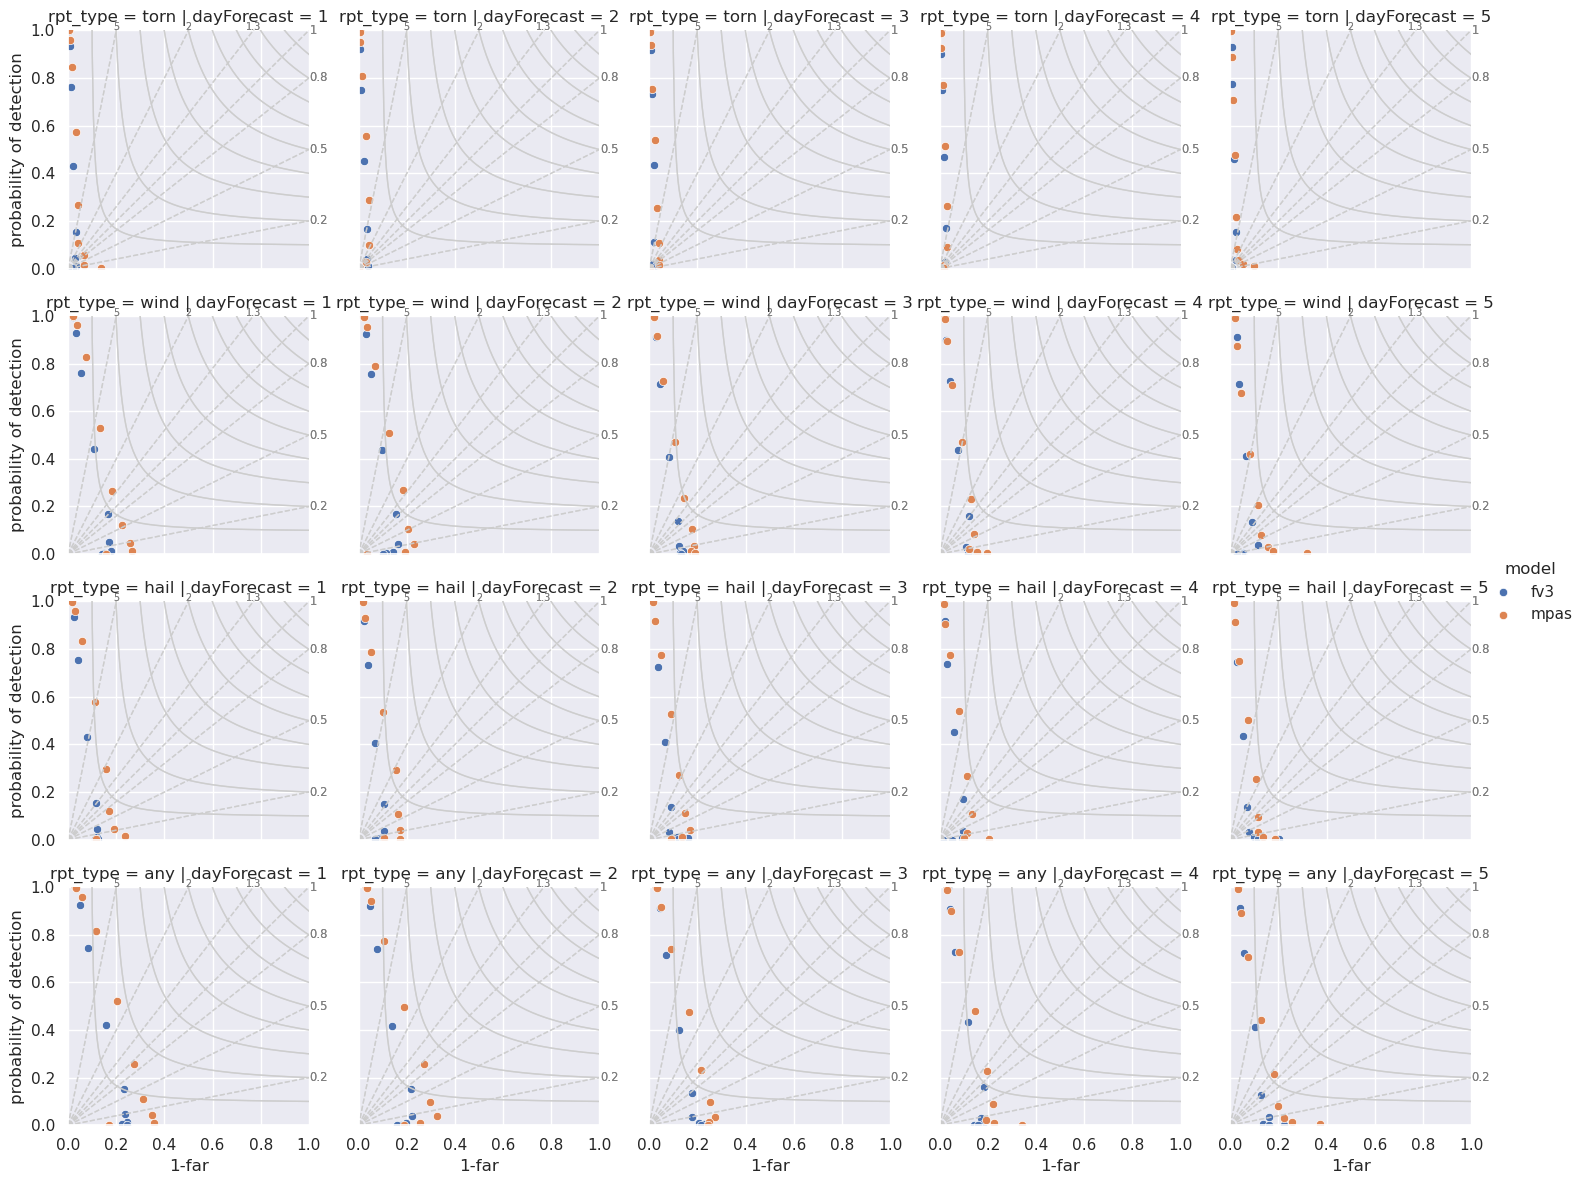

In [19]:
g = sns.FacetGrid(data, col="dayForecast", row="rpt_type", hue="model")
g.map(performance_diagram)
g.map(sns.scatterplot, "1-far", "probability of detection")
g.add_legend()

ofile = f"performance_diagram.day1-5.{variable}.png"
g.fig.savefig(ofile)
print(ofile)

/glade/derecho/scratch/ahijevyc/tmp/ets.2023-2024.wind2.10.25,25.10m speed max.day1-5avg.png


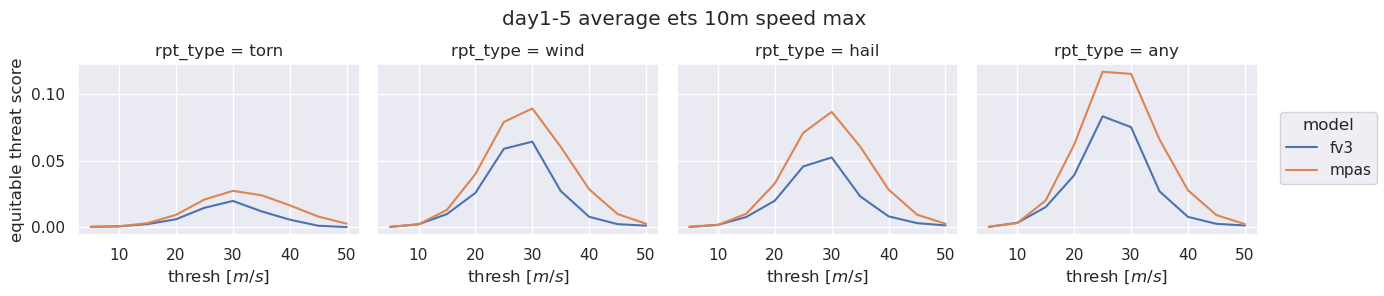

In [20]:
s = ets(hmfn.sel(dayForecast=slice(1, 5)).sum(dim="dayForecast").sum(dim="valid_date"))
g = s.sel(variable=variable).plot(col="rpt_type", hue="model")
ofile = tmpdir / f"{s.attrs['short_name']}{sfx.rstrip('.nc')}.{sel['variable']}.day1-5avg.png"
g.fig.suptitle(f"day1-5 average {s.attrs['short_name']} {variable}")
g.fig.subplots_adjust(top=0.8)
g.fig.savefig(ofile)
print(ofile)

## Calculate climatology
- Used in get_sl1l2 method above

In [21]:
O = hmfn.sel(count="hits") + hmfn.sel(count="misses")
climo = O / total(hmfn)
# use first dayForecast cause it has more early dates
# use first of everything else because they are all the same
s = climo.sel(dayForecast=1).isel(thresh=0, variable=0, model=0).mean(dim="valid_date")
s

<xarray.DataArray (rpt_type: 4)> Size: 32B
array([0.00394758, 0.01859965, 0.01432699, 0.02863584])
Coordinates:
    dayForecast  int64 8B 1
    thresh       int64 8B 5
    variable     <U13 52B 'updraft max'
  * rpt_type     (rpt_type) <U4 64B 'torn' 'wind' 'hail' 'any'
    model        <U4 16B 'fv3'

In [22]:
ifiles = list(datadir.glob("near_rpt.20??-??-?? ??:??:?[0-9].nc"))
print(len(ifiles))
climo = xarray.open_mfdataset(ifiles, combine="nested", concat_dim="time")
any = climo.max(dim="rpt_type").assign_coords(rpt_type="any")
climo = xarray.concat([climo, any], dim="rpt_type")

# Keep where conus_mask is True; otherwise set to nan.
# nans will not be counted when the .sum() function is used below.
climo = climo.where(conus_mask)
climo = (
    (climo == 1).sum(dim=["lon", "lat", "time"]) / (climo == 0).sum(dim=["lon", "lat", "time"])
).compute()
climo.near_rpts

80


<xarray.DataArray 'near_rpts' (rpt_type: 4)> Size: 32B
array([0.00396323, 0.01895215, 0.01453523, 0.02948002])
Coordinates:
  * rpt_type  (rpt_type) <U4 64B 'torn' 'wind' 'hail' 'any'

In [23]:
assert np.allclose(climo.near_rpts.values, s.values, rtol=0.03), f"{climo.near_rpts} {s}"

In [24]:
valid_date = pd.to_datetime("20230519")
model = "fv3"
thresh = thresholds[4]

fcst = get_fcst(datadir, model, group, valid_date)
example = "/glade/campaign/mmm/parc/schwartz/HWT2024/mpas/2024052100/post/mem_1/interp_mpas_3km_2024052100_mem1_f018.nc"
ds = xarray.open_dataset(example).squeeze()  # squeeze 1-element time dimension
fcst["lon"] = ds.longitude
fcst["lat"] = ds.latitude


# Define observations
obs = get_obs(datadir, valid_date)
obs["lon"] = ds.longitude
obs["lat"] = ds.latitude

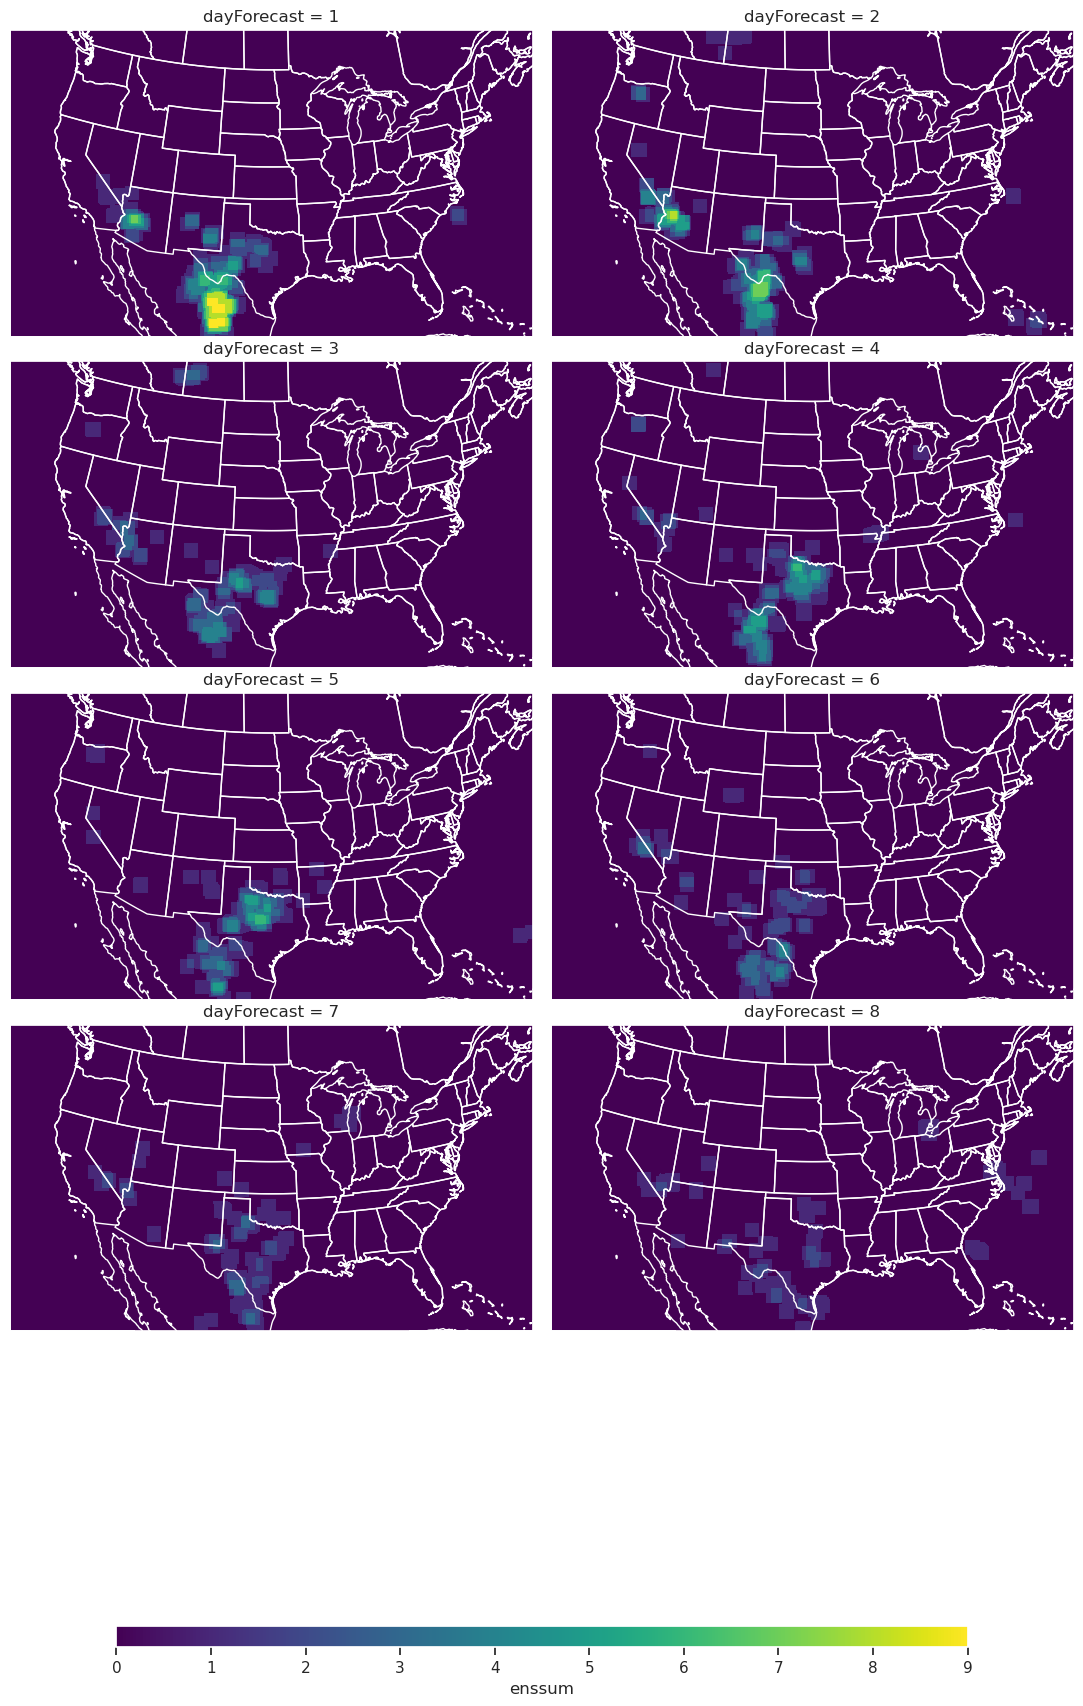

In [25]:
import cartopy

fg = fcst.sel(variable=variable, thresh=thresh).plot(
    col="dayForecast",
    col_wrap=2,
    transform=cartopy.crs.PlateCarree(),  # remember to provide this!
    subplot_kws={"projection": projection},
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.8, "aspect": 40},
    size=5,
)
fg.map(lambda: plt.gca().coastlines(color="white"))
fg.map(lambda: plt.gca().add_feature(cartopy.feature.STATES, edgecolor="white"))
fg.map(lambda: plt.gca().set_extent(extent))

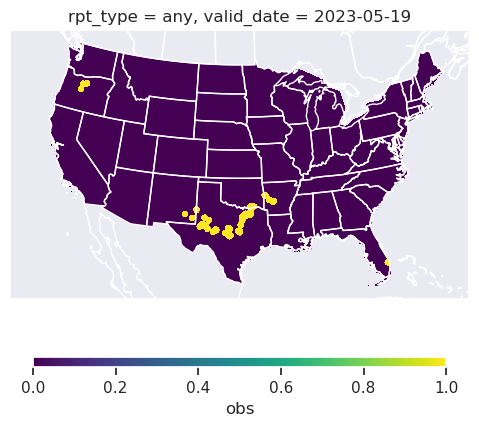

In [26]:
fg = obs.sel(rpt_type=rpt_type).plot(
    transform=cartopy.crs.PlateCarree(),  # remember to provide this!
    subplot_kws={"projection": projection},
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.8, "aspect": 40},
    size=5,
)
fg.axes.coastlines(color="white")
fg.axes.add_feature(cartopy.feature.STATES, edgecolor="white")
fg.axes.set_extent(extent)

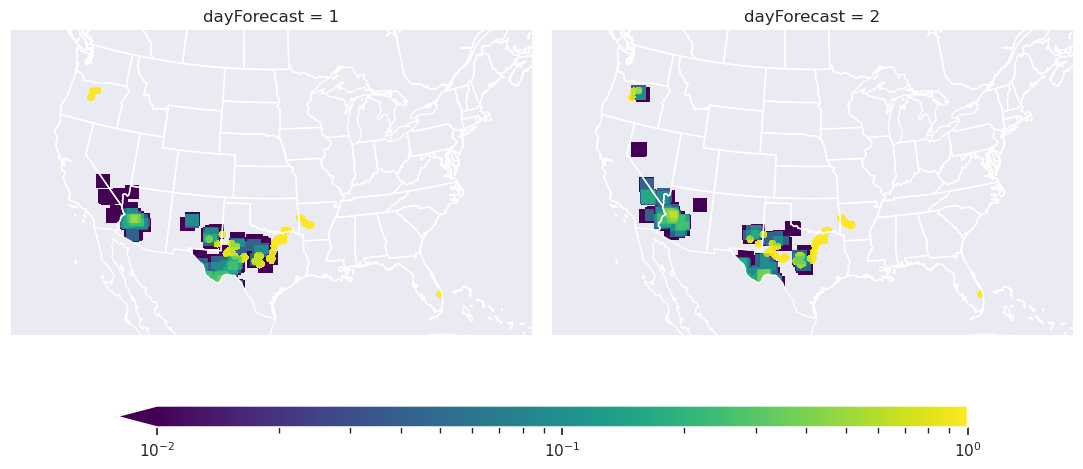

In [27]:
import matplotlib.colors as colors

bs = (fcst / fcst.attrs["nmem"] - obs) ** 2
fg = bs.sel(variable=variable, dayForecast=[1, 2], thresh=thresh, rpt_type=rpt_type).plot(
    col="dayForecast",
    col_wrap=2,
    transform=cartopy.crs.PlateCarree(),  # remember to provide this!
    subplot_kws={"projection": projection},
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.8, "aspect": 40},
    size=5,
    norm=colors.LogNorm(vmin=0.01, vmax=1),
)
fg.map(lambda: plt.gca().coastlines(color="white"))
fg.map(lambda: plt.gca().add_feature(cartopy.feature.STATES, edgecolor="white"))
fg.map(lambda: plt.gca().set_extent(extent))

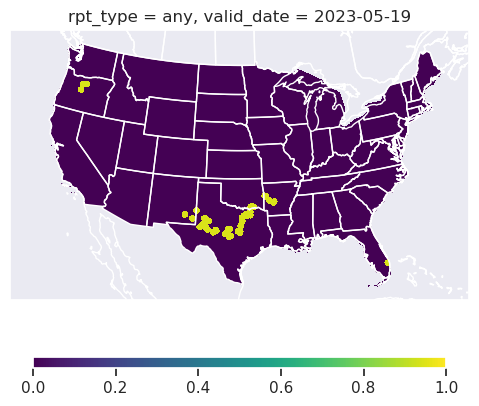

In [28]:
bsref = (climo.near_rpts - obs) ** 2
fg = bsref.sel(rpt_type=rpt_type).plot(
    transform=cartopy.crs.PlateCarree(),  # remember to provide this!
    subplot_kws={"projection": projection},
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.8, "aspect": 40},
    size=5,
    vmin=0,
    vmax=1,
)
fg.axes.coastlines(color="white")
fg.axes.add_feature(cartopy.feature.STATES, edgecolor="white")
fg.axes.set_extent(extent)

In [29]:
(1 - bs.mean(dim=["lat", "lon"]) / bsref.mean(dim=["lat", "lon"])).sel(
    variable=variable, thresh=thresh, rpt_type=rpt_type
)

<xarray.DataArray (dayForecast: 8)> Size: 64B
array([-0.06194459, -0.16064593,  0.14077129,  0.09409401,  0.11559827,
        0.01972436,  0.02848775,  0.03143038])
Coordinates:
  * dayForecast  (dayForecast) int64 64B 1 2 3 4 5 6 7 8
    thresh       int64 8B 25
    variable     <U13 52B '10m speed max'
    valid_date   datetime64[ns] 8B 2023-05-19
    rpt_type     <U4 16B 'any'

In [30]:
se = SL1L2.fcstfcst + SL1L2.obsobs - 2 * SL1L2.fcstobs
se_ref = SL1L2ref.fcstfcst + SL1L2ref.obsobs - 2 * SL1L2ref.fcstobs

(1 - se / se_ref).sel(
    model=model, valid_date=valid_date, variable=variable, thresh=thresh, rpt_type=rpt_type
)

<xarray.DataArray (dayForecast: 8)> Size: 64B
array([-0.06194462, -0.16064597,  0.14077126,  0.09409398,  0.11559825,
        0.01972433,  0.02848772,  0.03143036])
Coordinates:
  * dayForecast  (dayForecast) int64 64B 1 2 3 4 5 6 7 8
    thresh       int64 8B 25
    variable     <U13 52B '10m speed max'
    valid_date   datetime64[ns] 8B 2023-05-19
    model        <U4 16B 'fv3'
    rpt_type     <U4 16B 'any'